In [1]:
%reload_ext autoreload
%autoreload 2

from dimensions import IMU_OFFSET, STYLUS_LENGTH
from marker_tracker import CameraReading
from offline_playback import process_stroke, replay_data, merge_data, get_black_points, normalize_points
import numpy as np
from PIL import Image
import pickle
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from pyquaternion import Quaternion
import seaborn as sns

from offline_playback import ProcessedStroke

%matplotlib inline

recording_timestamp = "20230905_162344"
savefig_kwargs = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0}

scan_img = Image.open(f"./recordings/{recording_timestamp}/scan.jpg")
scan_dpi, _ = scan_img.info.get("dpi")
scan_x, scan_y = get_black_points(np.asarray(scan_img), scan_dpi)
scan_points = normalize_points(np.column_stack((scan_x, scan_y)))

def load_and_process(stylus_data_fname, camera_data_fname, smoothing_length=14, imu_skip=1, camera_skip=1):
    with open(
        f"./recordings/{recording_timestamp}/{stylus_data_fname}", "rb"
    ) as pickle_file:
        stylus_data = pickle.load(pickle_file)
    with open(
        f"./recordings/{recording_timestamp}/{camera_data_fname}", "rb"
    ) as pickle_file:
        camera_data = pickle.load(pickle_file)
    recorded_data = merge_data(stylus_data[1::imu_skip], camera_data[::camera_skip])
    tip_pos_predicted, tip_pos_smoothed, pressure, tip_pos_cameraonly, pressure_cameraonly = replay_data(
        recorded_data,
        dt=imu_skip/120,
        smoothing_length=smoothing_length,
        camera_delay=4//imu_skip,
    )
    
    s0, s1 = 70, -70
    cameraonly = process_stroke(tip_pos_cameraonly, scan_points, pressure_cameraonly)
    tpp = process_stroke(tip_pos_predicted[s0:s1, :], scan_points, pressure[s0:s1])
    tps = process_stroke(tip_pos_smoothed[s0:s1, :], scan_points, pressure[s0:s1])
    return tpp, tps, cameraonly

def stroke_to_linecollection(stroke: ProcessedStroke, width, color):
    xy = stroke.position * 1000
    x, y = xy[:, 0], xy[:, 1]
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    lc = LineCollection(segments)
    pressure_clip = np.clip(stroke.pressure, 0, 1)
    lc.set_linewidth((pressure_clip**0.7) * width)
    # alpha = np.sqrt(pressure_clip)[:,np.newaxis]
    # color_vec = np.array(color,  dtype=float) * alpha + (1 - alpha)
    lc.set_alpha(pressure_clip**0.3)
    lc.set_color(color)
    lc.set_rasterized(True)
    lc.set_capstyle("round")
    proxy = Line2D([0, 1], [0, 1], color=color, lw=width, solid_capstyle="round")
    return lc, proxy

def plot_scan_points(scan_points, ax=None):
    ax: Axes = sns.scatterplot(
        x=scan_points[:, 0] * 1000,
        y=scan_points[:, 1] * 1000,
        color=(0.8, 0.8, 1),
        s=5,
        alpha=0.6,
        linewidth=0,
        ax=ax,
    )
    ax.set_aspect("equal")
    ax.set(xlabel="x (mm)", ylabel="y (mm)", ylim=(-48,34))
    ax.collections[0].set_rasterized(True)
    return ax

def plot_strokes(ax, tpp, tps):
    lc1, lc1_proxy = stroke_to_linecollection(tpp, 1.5, color=(0.9, 0.6, 0.6))
    ax.add_collection(lc1)
    lc2, lc2_proxy = stroke_to_linecollection(tps, 2.3, color=(0, 0, 0))
    ax.add_collection(lc2)
    ax.legend(
        [ax.collections[0], lc1_proxy, lc2_proxy],
        [
            "Scan",
            f"Predicted stroke, before smoothing (d={tpp.dist_mean*1000:0.3f}mm)",
            f"Estimated stroke, after smoothing (d={tps.dist_mean*1000:0.3f}mm)",
        ],
        loc="lower left",
        markerscale=3,
    )

def mini_plot(tpp, tps, noleftlabels=False, ax=None):
    ax = plot_scan_points(scan_points, ax=ax)
    plot_strokes(ax, tpp, tps)
    ax.set(ylim=(-62, 34))
    if noleftlabels:
        ax.set(ylabel=None, yticklabels=[])
    return ax

## Main sketch plot

sample_count: 4627
Resetting state, errors: 0.28229554569920684, 1.1356149367548813


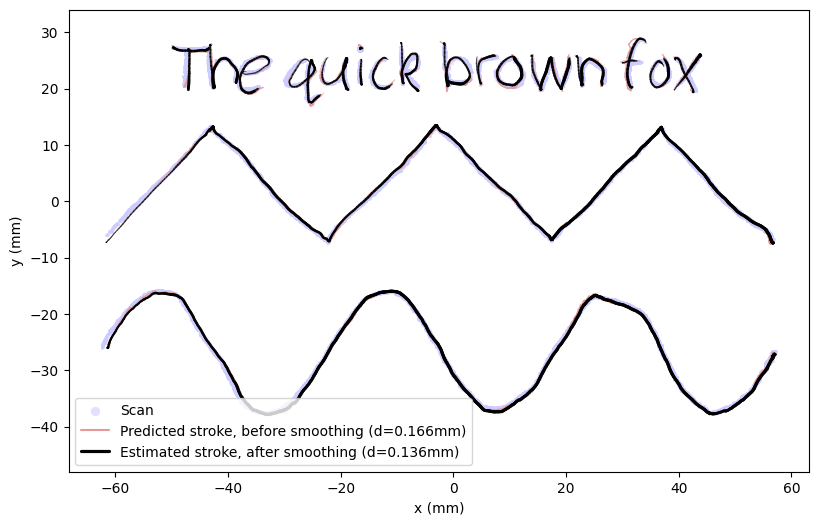

In [2]:
proposed_tpp, proposed_tps, proposed_cameraonly = load_and_process("stylus_data.pkl", "camera_data.pkl")
fig = plt.figure()
fig.set_size_inches(100,6)
ax = plot_scan_points(scan_points)
plot_strokes(ax, proposed_tpp, proposed_tps)

plt.savefig(f"./recordings/{recording_timestamp}/main-sketch-plot.pdf", **savefig_kwargs)

## Camera only

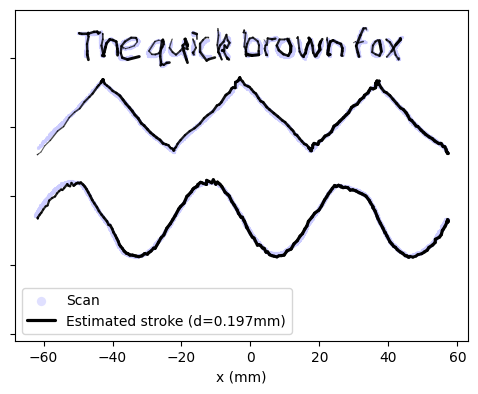

In [3]:
fig = plt.figure(figsize=(100,4.3))
ax = plot_scan_points(scan_points)
# _, _, proposed_cameraonly_10fps = load_and_process("stylus_data.pkl", "camera_data.pkl", camera_skip=3)
lc, lc_proxy = stroke_to_linecollection(proposed_cameraonly, 2.3, color=(0, 0, 0))
ax.add_collection(lc)
# plot_strokes(ax, tpp, tps)
ax.set(ylim=(-62, 34))
ax.set(ylabel=None, yticklabels=[])
ax.legend(
        [ax.collections[0], lc_proxy],
        [
            "Scan",
            f"Estimated stroke (d={proposed_cameraonly.dist_mean*1000:0.3f}mm)",
        ],
        loc="lower left",
        markerscale=3,
    )
plt.savefig(f"./recordings/{recording_timestamp}/cameraonly.pdf", **savefig_kwargs)

## Feature comparisons

In [4]:
nomarkercalib = load_and_process("stylus_data.pkl", "camera_data_nomarkercalib.pkl")
norsc = load_and_process("stylus_data.pkl", "camera_data_norsc.pkl")
epnp = load_and_process("stylus_data.pkl", "camera_data_epnp.pkl")
sqpnp = load_and_process("stylus_data.pkl", "camera_data_sqpnp.pkl")

sample_count: 4627
Resetting state, errors: 0.28199730820000646, 1.1353870650456785
sample_count: 4627
Resetting state, errors: 0.2823078918282777, 1.1355441331039036
sample_count: 4627
Resetting state, errors: 0.28238099756360474, 1.1361656252518821
sample_count: 4627
Resetting state, errors: 0.28240014234383687, 1.1341006184388103


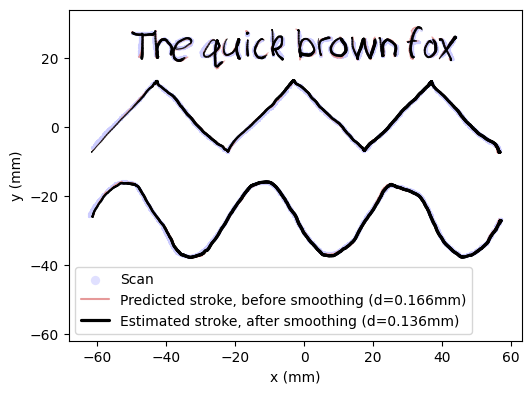

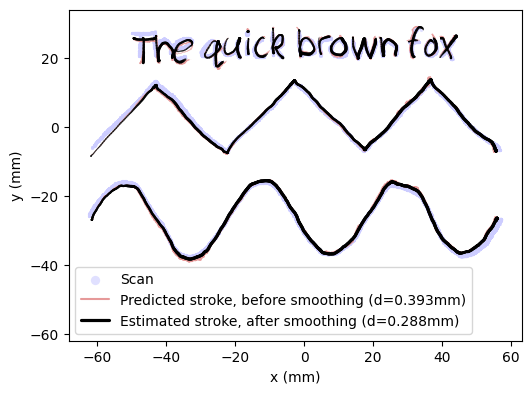

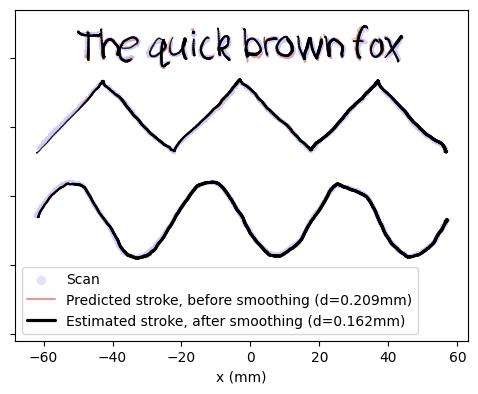

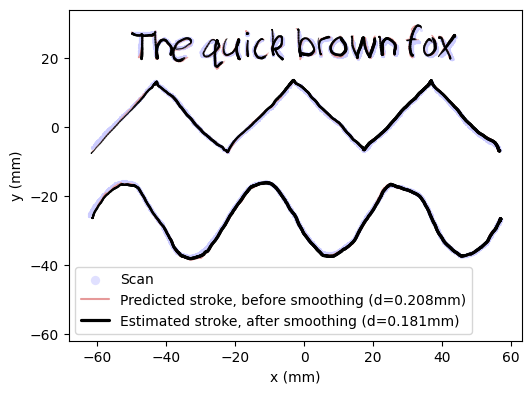

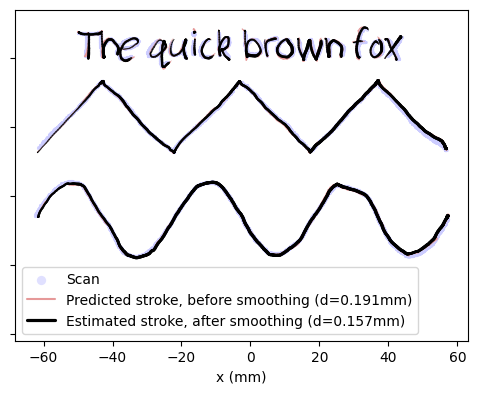

In [5]:
%matplotlib inline

fig = plt.figure(figsize=(100,4.3))
mini_plot(proposed_tpp, proposed_tps)
plt.savefig(f"./recordings/{recording_timestamp}/proposed.pdf", **savefig_kwargs)

fig = plt.figure(figsize=(100,4.3))
mini_plot(nomarkercalib[0], nomarkercalib[1])
plt.savefig(f"./recordings/{recording_timestamp}/nomarkercalib.pdf", **savefig_kwargs)

fig = plt.figure(figsize=(100,4.3))
mini_plot(norsc[0], norsc[1], noleftlabels=True)
plt.savefig(f"./recordings/{recording_timestamp}/norsc.pdf", **savefig_kwargs)

fig = plt.figure(figsize=(100,4.3))
mini_plot(epnp[0], epnp[1])
plt.savefig(f"./recordings/{recording_timestamp}/epnp.pdf", **savefig_kwargs)

fig = plt.figure(figsize=(100,4.3))
mini_plot(sqpnp[0], sqpnp[1], noleftlabels=True)
plt.savefig(f"./recordings/{recording_timestamp}/sqpnp.pdf", **savefig_kwargs)

## Smoothing

In [6]:
smoothing_lens = [0, 10, 50, 500]
smoothing_results = [
  load_and_process("stylus_data.pkl", "camera_data.pkl", smoothing_length=sl)
  for sl in smoothing_lens
]

sample_count: 4627
Resetting state, errors: 0.28229554569920684, 1.1356149367548813
sample_count: 4627
Resetting state, errors: 0.28229554569920684, 1.1356149367548813
sample_count: 4627
Resetting state, errors: 0.28229554569920684, 1.1356149367548813
sample_count: 4627
Resetting state, errors: 0.28229554569920684, 1.1356149367548813


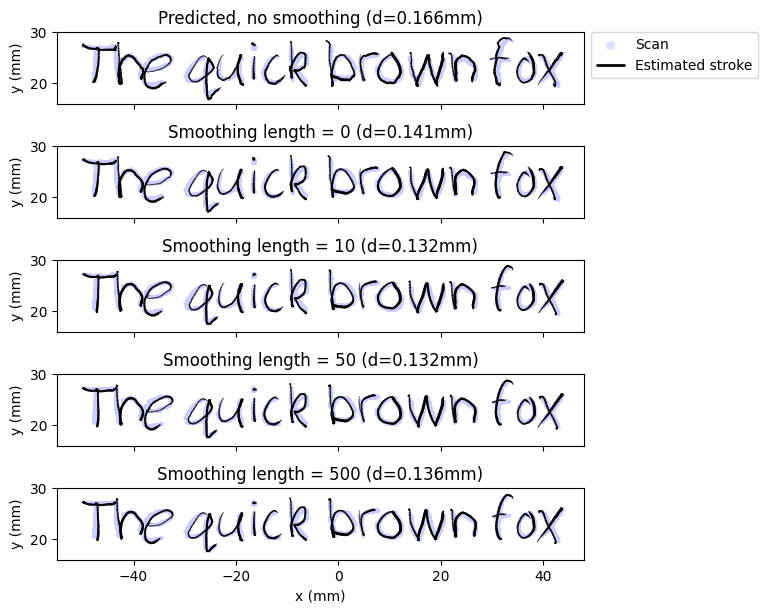

In [7]:
fig, axs = plt.subplots(len(smoothing_lens) + 1, 1, figsize=(6, 6), sharex=True)
fig.tight_layout()
lc_predicted, lc_proxy_predicted = stroke_to_linecollection(smoothing_results[0][0], 2, color=(0, 0, 0))
plot_scan_points(scan_points, ax=axs[0])
axs[0].add_collection(lc_predicted)
axs[0].set(xlim=(-55,48), ylim=(16, 30))
axs[0].set_title(f"Predicted, no smoothing (d={smoothing_results[0][0].dist_mean*1000:0.3f}mm)")
for i, sr in enumerate(smoothing_results):
    ax: Axes = axs[i+1]
    plot_scan_points(scan_points, ax=ax)
    # plot_strokes(ax, sr[0], sr[1], legend=False)
    lc, lc_proxy = stroke_to_linecollection(sr[1], 2, color=(0, 0, 0))
    ax.add_collection(lc)
    ax.set(xlim=(-55,48), ylim=(16, 30))
    ax.set_title(f"Smoothing length = {smoothing_lens[i]} (d={sr[1].dist_mean*1000:0.3f}mm)")

fig.legend(
    [axs[0].collections[0], lc_proxy_predicted],
    [
        "Scan",
        "Estimated stroke",
    ],
    # loc=(0.74, 0.89),
    loc='upper left',
    bbox_to_anchor=(1, 1.1),
    bbox_transform=axs[0].transAxes,
    markerscale=3,
)
plt.savefig(f"./recordings/{recording_timestamp}/smoothing-comparison.pdf", **savefig_kwargs)

## Camera frame rate

In [8]:
camera_skips = list(range(1, 11))
camera_skip_results = [
    load_and_process("stylus_data.pkl", "camera_data.pkl", camera_skip=cs, smoothing_length=10)
    for cs in camera_skips
]

sample_count: 4627
Resetting state, errors: 0.28229554569920684, 1.1356149367548813
sample_count: 4627
Resetting state, errors: 0.28123550915884665, 1.135661005419394
sample_count: 4627
Resetting state, errors: 0.27878472635880275, 1.1357533114576115
sample_count: 4627
Resetting state, errors: 0.2640883114009815, 1.1361877279909536
sample_count: 4627
Resetting state, errors: 0.2538705047829204, 1.1365916334273223
sample_count: 4627
Resetting state, errors: 0.23981733567320207, 1.137132951215645
sample_count: 4627
Resetting state, errors: 0.2314841967113648, 1.137077659957953
sample_count: 4627
Resetting state, errors: 0.22980556971227678, 1.1374712859610077
sample_count: 4627
Resetting state, errors: 0.24084398830693868, 1.1376231707322677
sample_count: 4627
Resetting state, errors: 0.27359927954119406, 1.137838277026285


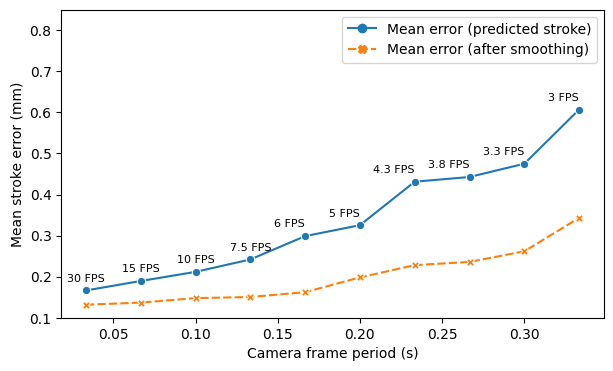

In [9]:
import pandas as pd
import scipy.optimize
camera_skip_df = pd.DataFrame(
    {
        "camera_skip": camera_skips,
        "fps": [30/cs for cs in camera_skips],
        "period": [cs/30 for cs in camera_skips],
        "Mean error (predicted stroke)": [sr[0].dist_mean*1000 for sr in camera_skip_results],
        "Mean error (after smoothing)": [sr[1].dist_mean*1000 for sr in camera_skip_results],
    }
)

def plot_error_vs_camera_skip(camera_skip_df):
    fig = plt.figure(figsize=(7, 4))
    ax: Axes = sns.lineplot(
        x="period",
        y="value",
        style="variable",
        hue="variable",
        markers=True,
        data=pd.melt(camera_skip_df, ["camera_skip", "period", "fps"]),
        legend="brief",
    )

    # ax.set(xticks=list(range(30, 0, -5)) + [3])
    ax.set(xlabel="Camera frame period (s)", ylabel="Mean stroke error (mm)", ylim=(0.1, 0.85))
    # ax.invert_xaxis()
    ax.get_legend().set_title(None)

    # def quad(x, a, b):
    #     return x * x * a + b

    # fit1, _ = scipy.optimize.curve_fit(quad, camera_skip_df.period, camera_skip_df["Mean error (after smoothing)"])

    # ax.plot(camera_skip_df.period, quad(camera_skip_df.period, *fit1), "k--", linewidth=1)

    for row in camera_skip_df.itertuples():
        ax.annotate(
            f"{row.fps:.2g} FPS",
            (row.period, row[4]),
            xytext=(0, 5),
            textcoords="offset points",
            ha="right" if row.fps <= 6 else "center",
            va="bottom", # if row.fps >= 5 else "top",
            fontsize=8,
        )

plot_error_vs_camera_skip(camera_skip_df)
plt.savefig(f"./recordings/{recording_timestamp}/error-vs-camera-period.pdf", **savefig_kwargs)

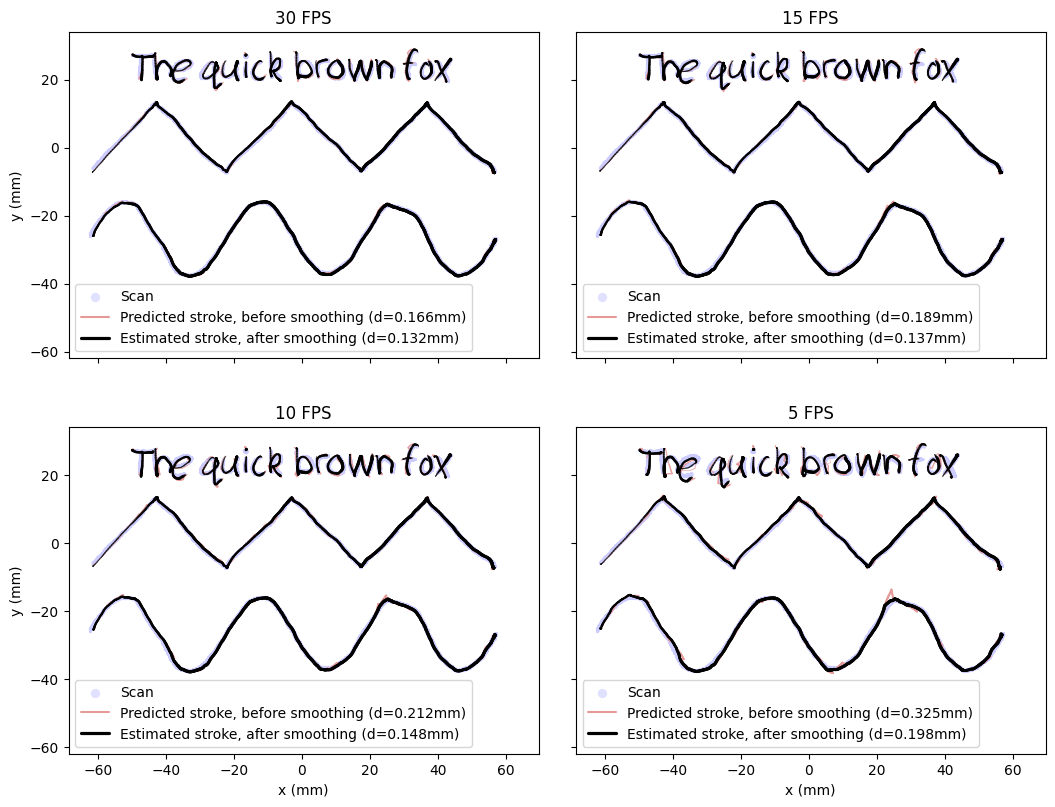

In [11]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.5, 8.5))
# plt.subplot()
fig.tight_layout()
fig.subplots_adjust(hspace=0)
for i in range(4):
    j = [0, 1, 2, 5][i]
    res_tpp, res_tps, _ = camera_skip_results[j]
    ax = mini_plot(res_tpp, res_tps, ax=axs.flat[i])
    ax.set_title(f"{30/camera_skips[j]:.0f} FPS")

def get_camera_points(stroke: ProcessedStroke):
    pos = stroke.position[stroke.pressure > 0.05,:]
    xy = pos[::120//30,:] * 1000
    x, y = xy[:, 0], xy[:, 1]
    return x, y
# ax.scatter(*get_camera_points(camera_skip_results[3][1]), s=6, marker='.', zorder=10)
plt.savefig(f"./recordings/{recording_timestamp}/camera-fps-comparison.pdf", **savefig_kwargs)